In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from livelossplot.keras import PlotLossesCallback
import matplotlib.pyplot as plt
import seaborn as sns

from hyperas.distributions import uniform, choice
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from keras import regularizers
from keras.callbacks import LearningRateScheduler, Callback
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import keras

Using TensorFlow backend.


In [2]:
## For reproducibility
from numpy.random import seed
seed(9251996)

In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 40:
        lrate = 0.0005
    if epoch > 60:
        lrate = 0.0003
    if epoch > 80:
        lrate = 0.0001
    if epoch > 100:
        lrate = 0.00003  
    return lrate

In [4]:
def data():
    train_values = pd.read_csv('train_values.csv', index_col='patient_id')
    train_labels = pd.read_csv('train_labels.csv', index_col='patient_id')
    train_labels.heart_disease_present.value_counts().plot.bar(title='Number with Heart Disease')
    #selected_features = ['age', 
    #                     'sex', 
    #                     'max_heart_rate_achieved', 
    #                     'resting_blood_pressure']
    selected_features =['slope_of_peak_exercise_st_segment',
    'thal',
    'resting_blood_pressure',
    'chest_pain_type',
    'num_major_vessels',
    'fasting_blood_sugar_gt_120_mg_per_dl',
    'resting_ekg_results',
    'serum_cholesterol_mg_per_dl',
    'oldpeak_eq_st_depression',
    'sex',
    'age',
    'max_heart_rate_achieved',
    'exercise_induced_angina']
    train_values_subset = train_values[selected_features]
    train_values_subset['thal']= pd.factorize(train_values_subset.thal)[0]
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    predictors = pd.DataFrame(x_scaler.fit_transform(train_values_subset), columns=train_values_subset.columns)
    #target = pd.DataFrame(y_scaler.fit_transform(train_labels), columns=['heart_disease_present'])
    #predictors =train_values_subset
    target = train_labels.heart_disease_present
    X_train,X_val,Y_train,Y_val = train_test_split(predictors,target,test_size=0.10,random_state=0)

    return X_train, Y_train,X_val,Y_val

In [5]:
def create_model(X_train, Y_train,X_val,Y_val):
    """
    Keras model function.
    """

    inshape = 13
    outshape = 1

    model = Sequential()
    
    model.add(Dense({{ choice(range(257)) }},input_shape=(inshape,)))
    model.add(Activation({{ choice(['relu','elu']) }})) ## Choose between relu or signmoid activation
    model.add(Dropout({{ uniform(0,1) }})) ## Choose dropout value using uniform distribution of values from 0 to 1
    
    model.add(Dense({{ choice(range(257)) }}))
    model.add(Activation({{ choice(['relu','elu']) }}))
    model.add(Dropout({{ uniform(0,1) }}))
    
    model.add(Dense({{ choice(range(257)) }}))
    model.add(Activation({{ choice(['relu','elu']) }}))
    model.add(Dropout({{ uniform(0,1) }}))

    model.add(Dense(outshape))
    model.add(Activation('sigmoid'))
   #model.add(Activation({{choice(['softmax','sigmoid']) }}))

    ## Hyperparameterization of optimizers and learning rate
    _adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    _rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    _sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})

    opt_choiceval = {{ choice( ['_adam', '_rmsprop', '_sgd'] ) }}

    if opt_choiceval == '_adam':
        optim = _adam
    elif opt_choiceval == '_rmsprop':
        optim = _rmsprop
    else:
        optim = _sgd
                      
    model.summary()
    model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optim)
                      
    model.fit(X_train, Y_train,
        batch_size=32,
        epochs=50,
        verbose=2,
        validation_data=(X_val, Y_val), callbacks=[PlotLossesCallback()])

    loss, acc = model.evaluate(X_val, Y_val)
    predicted = model.predict(X_val)

    print('Logarithmic Loss:', loss)
    return {'loss': 0+loss, 'status': STATUS_OK, 'model': model}


In [6]:
def main():

    trials =Trials()
    best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=30,
                                          trials=trials,
                                        notebook_name='model6')
    X_train, Y_train, X_val, Y_val = data()
    print("\n >> Hyperparameters  ")
    for t in best_run.items():
        print("[**] ",t[0],": ", t[1])

    print("\nSaving model...")
    model_json = best_model.to_json()
    with open("model_num.json","w") as json_file:
        json_file.write(model_json)
    best_model.save_weights("model7.h5")


In [7]:
def predict():
    selected_features =['slope_of_peak_exercise_st_segment',
    'thal',
    'resting_blood_pressure',
    'chest_pain_type',
    'num_major_vessels',
    'fasting_blood_sugar_gt_120_mg_per_dl',
    'resting_ekg_results',
    'serum_cholesterol_mg_per_dl',
    'oldpeak_eq_st_depression',
    'sex',
    'age',
    'max_heart_rate_achieved',
    'exercise_induced_angina']
    test_values = pd.read_csv('test_values.csv', index_col='patient_id')
    testing = test_values[selected_features]
    testing['thal']= pd.factorize(testing.thal)[0]
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_test = pd.DataFrame(x_scaler.fit_transform(testing), columns=testing.columns)
    # name = sys.argv[1]
    json_file = open("model_num.json" , 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model7.h5")
    print("Loaded model...")

    # evaluate loaded model on test data

    predictions=loaded_model.predict(X_test, batch_size=128)
    submission_format = pd.read_csv('submission_format.csv', index_col='patient_id')
    my_submission = pd.DataFrame(data=predictions,
                         columns=submission_format.columns,
                         index=submission_format.index)
    my_submission.head()
    my_submission.to_csv('submission8.csv')



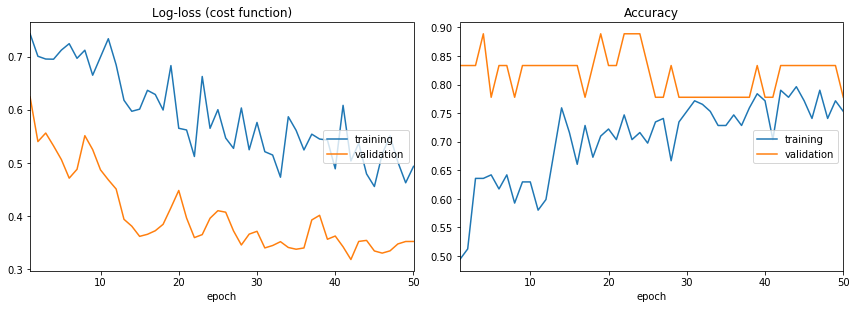

Log-loss (cost function):                                                      
training   (min:    0.456, max:    0.743, cur:    0.494)
validation (min:    0.319, max:    0.624, cur:    0.352)

Accuracy:
training   (min:    0.494, max:    0.796, cur:    0.753)
validation (min:    0.778, max:    0.889, cur:    0.778)
18/18 [==============================]                                         
 - 0s 222us/step                                                               

Logarithmic Loss:                                                              
0.3524177372455597                                                             
100%|███████████| 30/30 [14:21<00:00, 30.21s/it, best loss: 0.2922276556491852]


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 >> Hyperparameters  
[**]  Activation :  0
[**]  Activation_1 :  1
[**]  Activation_2 :  0
[**]  Activation_3 :  1
[**]  Dense :  200
[**]  Dense_1 :  225
[**]  Dense_2 :  222
[**]  Dropout :  0.8159759925994534
[**]  Dropout_1 :  0.7870663751814376
[**]  Dropout_2 :  0.524631171571892
[**]  lr :  1
[**]  lr_1 :  2
[**]  lr_2 :  2
[**]  opt_choiceval :  0

Saving model...
done.. Training


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Loaded model...


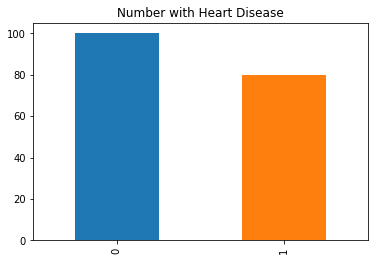

In [8]:
main()
print("done.. Training")
predict()